In [1]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks

    dname = "nb011-ner-conll"
    os.makedirs(dname, exist_ok=True)


    !pip install --upgrade --force-reinstall --no-deps kaggle
    import json
    f = open("/content/drive/MyDrive/colab_notebooks/kaggle/kaggle.json", "r")
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    !nvidia-smi

Mounted at /content/drive
/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks
     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=76f11b984fd9639e27a6809a4e830e01d21053dd5d8ec9ff924b3a85999a60cd
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Sun Jun  6 12:33:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M.

In [2]:
if 'google.colab' in sys.modules:
    %cd /content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/input
    folder = "embeddings"
    if not os.path.exists(f"./{folder}/glove.6B.100d.txt"):
        os.makedirs(folder, exist_ok=True)
        
        print("Starting to download the embedding file...")
        !wget http://nlp.stanford.edu/data/glove.6B.zip -P {folder}
        print("...Done")

        print("Starting to unzip the downloaded file...")
        !unzip {folder}/glove.6B.zip -d {folder}
        !rm {folder}/glove.6B.zip
        print("...Done")

    # back to the original directory
    %cd /content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks

/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/input
/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks


In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf 
print("tf.__version__: ", tf.__version__)
from tensorflow.keras import layers
from fastprogress.fastprogress import master_bar, progress_bar

try:
    from seqeval.metrics import classification_report
except ModuleNotFoundError:
    !pip install seqeval
    from seqeval.metrics import classification_report

tf.__version__:  2.5.0
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=48b32b59d169d0008498a6217f8cca785e7ccba6345d3d3331587a2a72b491f1
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [4]:
class Args:
    use_tf = False
    data = "../input/conll003-englishversion"
    max_seq_len = 128
    
    train_batch_size = 32
    valid_batch_size = 64
    test_batch_size = 64

    embedding_dim = 100
    epochs = 10
    output = "nb011-ner-conll"
    
args = Args()

max_seq_len = args.max_seq_len
EMBEDDING_DIM = args.embedding_dim
train_batch_size = args.train_batch_size
valid_batch_size = args.valid_batch_size
test_batch_size = args.test_batch_size
epochs = args.epochs

***
# Preprocessing

In [5]:
def split_text_label(filename):
    f = open(filename)
    split_labeled_text = []
    sentence = []
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                split_labeled_text.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0],splits[-1].rstrip("\n")])
    
    if len(sentence) > 0:
        split_labeled_text.append(sentence)
        sentence = []
    return split_labeled_text

In [6]:
split_train = split_text_label(os.path.join(args.data, "train.txt"))
split_valid = split_text_label(os.path.join(args.data, "valid.txt"))
split_test = split_text_label(os.path.join(args.data, "test.txt"))

In [7]:
split_train[:3]

[[['EU', 'B-ORG'],
  ['rejects', 'O'],
  ['German', 'B-MISC'],
  ['call', 'O'],
  ['to', 'O'],
  ['boycott', 'O'],
  ['British', 'B-MISC'],
  ['lamb', 'O'],
  ['.', 'O']],
 [['Peter', 'B-PER'], ['Blackburn', 'I-PER']],
 [['BRUSSELS', 'B-LOC'], ['1996-08-22', 'O']]]

In [8]:
split_valid[:3]

[[['CRICKET', 'O'],
  ['-', 'O'],
  ['LEICESTERSHIRE', 'B-ORG'],
  ['TAKE', 'O'],
  ['OVER', 'O'],
  ['AT', 'O'],
  ['TOP', 'O'],
  ['AFTER', 'O'],
  ['INNINGS', 'O'],
  ['VICTORY', 'O'],
  ['.', 'O']],
 [['LONDON', 'B-LOC'], ['1996-08-30', 'O']],
 [['West', 'B-MISC'],
  ['Indian', 'I-MISC'],
  ['all-rounder', 'O'],
  ['Phil', 'B-PER'],
  ['Simmons', 'I-PER'],
  ['took', 'O'],
  ['four', 'O'],
  ['for', 'O'],
  ['38', 'O'],
  ['on', 'O'],
  ['Friday', 'O'],
  ['as', 'O'],
  ['Leicestershire', 'B-ORG'],
  ['beat', 'O'],
  ['Somerset', 'B-ORG'],
  ['by', 'O'],
  ['an', 'O'],
  ['innings', 'O'],
  ['and', 'O'],
  ['39', 'O'],
  ['runs', 'O'],
  ['in', 'O'],
  ['two', 'O'],
  ['days', 'O'],
  ['to', 'O'],
  ['take', 'O'],
  ['over', 'O'],
  ['at', 'O'],
  ['the', 'O'],
  ['head', 'O'],
  ['of', 'O'],
  ['the', 'O'],
  ['county', 'O'],
  ['championship', 'O'],
  ['.', 'O']]]

In [9]:
split_test[:3]

[[['SOCCER', 'O'],
  ['-', 'O'],
  ['JAPAN', 'B-LOC'],
  ['GET', 'O'],
  ['LUCKY', 'O'],
  ['WIN', 'O'],
  [',', 'O'],
  ['CHINA', 'B-PER'],
  ['IN', 'O'],
  ['SURPRISE', 'O'],
  ['DEFEAT', 'O'],
  ['.', 'O']],
 [['Nadim', 'B-PER'], ['Ladki', 'I-PER']],
 [['AL-AIN', 'B-LOC'],
  [',', 'O'],
  ['United', 'B-LOC'],
  ['Arab', 'I-LOC'],
  ['Emirates', 'I-LOC'],
  ['1996-12-06', 'O']]]

In [10]:
labelSet = set()
wordSet = set()
# words and labels
for data in [split_train, split_valid, split_test]:
    for labeled_text in data:
        for word, label in labeled_text:
            labelSet.add(label)
            wordSet.add(word.lower())

In [11]:
print(labelSet)
#print(wordSet)

{'O', 'I-LOC', 'B-MISC', 'B-LOC', 'I-PER', 'B-PER', 'I-MISC', 'B-ORG', 'I-ORG'}


In [12]:
# Sort the set to ensure '0' is assigned to 0
sorted_labels = sorted(list(labelSet), key=len)

# Create mapping for labels
label2Idx = {}
for label in sorted_labels:
    label2Idx[label] = len(label2Idx)
num_labels = len(label2Idx)
idx2Label = {v: k for k, v in label2Idx.items()}



# Create mapping for words
word2Idx = {}
if len(word2Idx) == 0:
    word2Idx["PADDING_TOKEN"] = len(word2Idx)
    word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
for word in wordSet:
    word2Idx[word] = len(word2Idx)

In [13]:
def createMatrices(data, word2Idx, label2Idx):
    sentences = []
    labels = []
    for split_labeled_text in data:
        wordIndices = []
        labelIndices = []
        for word, label in split_labeled_text:
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]
            else:
                wordIdx = word2Idx['UNKNOWN_TOKEN']
            wordIndices.append(wordIdx)
            labelIndices.append(label2Idx[label])
        sentences.append(wordIndices)
        labels.append(labelIndices)
    return sentences, labels

In [14]:
train_sentences, train_labels = createMatrices(split_train, word2Idx, label2Idx)
valid_sentences, valid_labels = createMatrices(split_valid, word2Idx, label2Idx)
test_sentences, test_labels = createMatrices(split_test, word2Idx, label2Idx)

In [15]:
train_sentences[:3]

[[13371, 12166, 1387, 5658, 10976, 7498, 7314, 23965, 7735],
 [10319, 17638],
 [23230, 5102]]

In [16]:
train_labels[:3]

[[5, 0, 7, 0, 0, 0, 7, 0, 0], [4, 3], [2, 0]]

max length: 113 
min length: 1


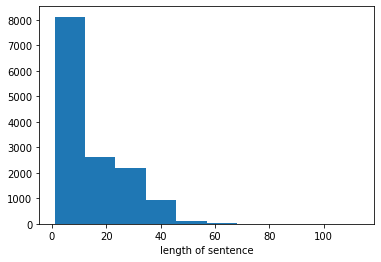

In [17]:
tmp = [len(sentence) for sentence in train_sentences]
print(f"max length: {np.max(tmp)} \nmin length: {np.min(tmp)}")
plt.hist(tmp)
plt.xlabel('length of sentence');

In [18]:
def padding(sentences, labels, max_len, padding='post'):
    padded_sentences = pad_sequences(sentences, max_len, padding='post')
    padded_labels = pad_sequences(labels, max_len, padding='post')
    return padded_sentences, padded_labels

In [19]:
train_features, train_labels = padding(train_sentences, train_labels, max_seq_len, padding='post')
valid_features, valid_labels = padding(valid_sentences, valid_labels, max_seq_len, padding='post')
test_features, test_labels = padding(test_sentences, test_labels, max_seq_len, padding='post')

In [20]:
train_features

array([[13371, 12166,  1387, ...,     0,     0,     0],
       [10319, 17638,     0, ...,     0,     0,     0],
       [23230,  5102,     0, ...,     0,     0,     0],
       ...,
       [22061,  2417, 26266, ...,     0,     0,     0],
       [22076, 18370,     0, ...,     0,     0,     0],
       [18735,  1038,   733, ...,     0,     0,     0]], dtype=int32)

In [21]:
train_features.shape

(14041, 128)

In [22]:
train_labels.shape

(14041, 128)

In [23]:
# Loading glove embeddings
embeddings_index = {}
f = open('../input/embeddings/glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.strip().split(' ')
    word = values[0] # the first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') #100d vectors representing the word
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((len(word2Idx), EMBEDDING_DIM))

In [24]:
# Word embeddings for the tokens
for word,i in word2Idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix.shape

(26871, 100)

***
# Train

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_features, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

In [27]:
shuffled_train_dataset = train_dataset.shuffle(buffer_size=train_features.shape[0], reshuffle_each_iteration=True)
batched_train_dataset = shuffled_train_dataset.batch(train_batch_size, drop_remainder=True)
batched_valid_dataset = valid_dataset.batch(valid_batch_size, drop_remainder=True)
batched_test_dataset = test_dataset.batch(test_batch_size, drop_remainder=True)

In [28]:
class TFNer(tf.keras.Model):
    def __init__(self, max_seq_len, embed_input_dim, embed_output_dim, num_labels, weights):
        super(TFNer, self).__init__() 
        self.embedding = layers.Embedding(input_dim=embed_input_dim, 
                                          output_dim=embed_output_dim, 
                                          weights=weights,   
                                          input_length=max_seq_len,
                                          trainable=False, 
                                          mask_zero=True)        

        self.bilstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        self.dense = layers.Dense(num_labels)
    
    def call(self, inputs):
        x = self.embedding(inputs) # batchsize, max_seq_len, embedding_output_dim
        x = self.bilstm(x) #batchsize, max_seq_len, hidden_dim_bilstm
        logits = self.dense(x) #batchsize, max_seq_len, num_labels
        return logits

In [29]:
model = TFNer(max_seq_len=max_seq_len,
              embed_input_dim=len(word2Idx),
              embed_output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix], 
              num_labels=num_labels)

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [31]:
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
valid_loss_metric = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32)

In [33]:
def train_step_fn(sentences_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits = model(sentences_batch)
        loss = scce(labels_batch, logits)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
    return loss, logits

def valid_step_fn(sentences_batch, labels_batch):
    logits = model(sentences_batch)
    loss = scce(labels_batch, logits)
    return loss, logits

In [34]:
epoch_bar = master_bar(range(epochs))
train_pb_max_len = math.ceil(float(len(train_features))/float(train_batch_size))
valid_pb_max_len = math.ceil(float(len(valid_features))/float(valid_batch_size))
test_pb_max_len = math.ceil(float(len(test_features))/float(test_batch_size))

In [35]:
# import time

# def measure(x, steps):
#   # TensorFlow initializes a GPU the first time it's used, exclude from timing.
#   tf.matmul(x, x)
#   start = time.time()
#   for i in range(steps):
#     x = tf.matmul(x, x)
#   # tf.matmul can return before completing the matrix multiplication
#   # (e.g., can return after enqueing the operation on a CUDA stream).
#   # The x.numpy() call below will ensure that all enqueued operations
#   # have completed (and will also copy the result to host memory,
#   # so we're including a little more than just the matmul operation
#   # time).
#   _ = x.numpy()
#   end = time.time()
#   return end - start

# shape = (1000, 1000)
# steps = 200
# print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))


# # Run on GPU, if available:
# if tf.config.list_physical_devices("GPU"):
#   with tf.device("/gpu:0"):
#     print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
# else:
#   print("GPU: not found")

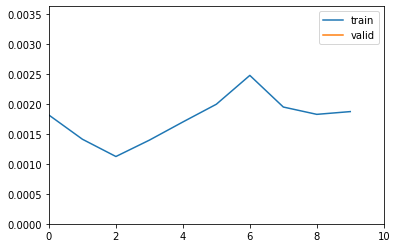

In [39]:
# 学習曲線描画のための前準備
train_losses_epoch = []
valid_losses_epoch = []
x_bounds = [0, epochs]
y_bounds = None
y_upper_bound = None
for epoch in epoch_bar:
    
    train_losses = []
    for sentences_batch, labels_batch in progress_bar(batched_train_dataset, total=train_pb_max_len, parent=epoch_bar):
        loss, logits = train_step_fn(sentences_batch, labels_batch)
        train_losses.append(loss)
        train_loss_metric(loss)
    train_loss_metric.reset_states()
    
    valid_losses = []
    for sentences_batch, labels_batch in progress_bar(batched_valid_dataset, total=valid_pb_max_len, parent=epoch_bar):
        loss, logits = valid_step_fn(sentences_batch, labels_batch)
        valid_losses.append(loss)
        valid_loss_metric.update_state(loss)
    valid_loss_metric.reset_states()


    train_loss_mean = np.mean(train_losses)
    valid_loss_mean = np.mean(valid_losses)
    train_losses_epoch.append(train_loss_mean)
    valid_losses_epoch.append(valid_loss_mean)


    # learning curveの図示
    if y_bounds is None:
        # 1エポック目のみ実行
        y_bounds = [0, train_loss_mean*2 if y_upper_bound is None else y_upper_bound]

    t = np.arange(len(train_losses_epoch))
    graphs = [[t, train_losses_epoch], [t, valid_losses_epoch]]
    epoch_bar.update_graph(graphs, x_bounds, y_bounds)

    # 学習過程の出力
    epoch_bar.write(f'EPOCH: {epoch+1:02d}, Training loss: {train_loss_mean:10.5f}, Validation loss: {valid_loss_mean:10.5f}')

In [60]:
model.save_weights(f"./{args.output}/model_weights", save_format='tf')

***
# Inference

In [41]:
def idx_to_label(predictions, correct, idx2Label):
    
    label_pred = []
    for sentence in predictions:
        for i in sentence:
            label_pred.append([idx2Label[elem] for elem in i])
    
    label_correct = []
    if correct != None:
        for sentence in correct:
            for i in sentence:
                label_correct.append([idx2Label[elem] for elem in i])
    
    return label_correct, label_pred

In [42]:
test_model =  TFNer(max_seq_len=max_seq_len, 
                    embed_input_dim=len(word2Idx), 
                    embed_output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    num_labels=num_labels)
test_model.load_weights(f"{args.output}/model_weights")

In [50]:
true_labels = []
pred_labels = []
for sentences_batch, labels_batch in progress_bar(batched_test_dataset, total=test_pb_max_len):
    logits = test_model(sentences_batch)
    temp1 = tf.nn.softmax(logits)
    preds = tf.argmax(temp1, axis=2)
    true_labels.append(np.asarray(labels_batch))
    pred_labels.append(np.asarray(preds))

label_correct, label_pred = idx_to_label(pred_labels, true_labels, idx2Label)
report = classification_report(label_correct, label_pred, digits=4)
print(report)

              precision    recall  f1-score   support

         LOC     0.0037    0.0030    0.0033      1651
        MISC     0.6667    0.6745    0.6706       682
         ORG     0.0219    0.0311    0.0257      1610
         PER     0.1381    0.2738    0.1836      1596

   micro avg     0.1269    0.1719    0.1460      5539
   macro avg     0.2076    0.2456    0.2208      5539
weighted avg     0.1293    0.1719    0.1439      5539

